In [1]:
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc

from six.moves import urllib
from IPython.display import clear_output

In [2]:
# Load dataset.

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

### EDA

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

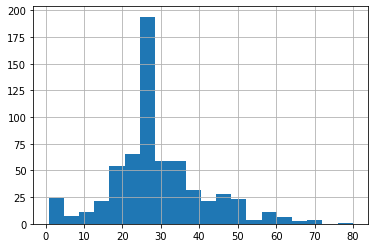

In [6]:
dftrain.age.hist(bins = 20)

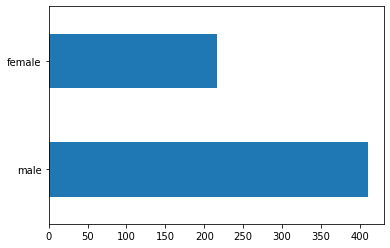

In [7]:
dftrain.sex.value_counts().plot(kind = 'barh')

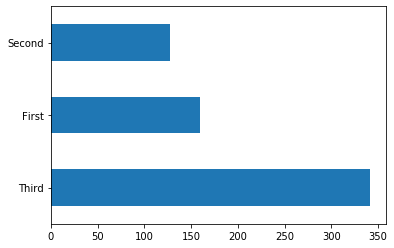

In [8]:
dftrain['class'].value_counts().plot(kind = 'barh')

Text(0.5, 0, '% survive')

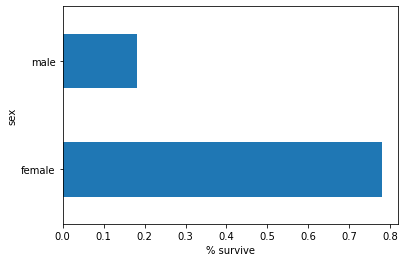

In [9]:
pd.concat([dftrain, y_train], axis = 1).groupby('sex').survived.mean().plot(kind = 'barh').set_xlabel('% survive')

### Build Preprocessing Pipeline

In [10]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float32))

In [11]:
def make_input_fn(data_df, label_df, num_epochs = 10, shuffle = True, batch_size = 32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs = 1, shuffle = False)

In [12]:
# Inspect

ds = make_input_fn(dftrain, y_train, batch_size = 10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Second' b'Third' b'First' b'Third' b'First' b'Third' b'Third' b'Second'
 b'Third' b'First']

A batch of Labels: [1 1 0 0 1 0 0 0 0 1]


In [13]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[34.],
       [28.],
       [50.],
       [16.],
       [28.],
       [25.],
       [28.],
       [47.],
       [28.],
       [31.]], dtype=float32)

DenseFeatures only accepts dense tensors, to inspect a categorical column you need to transform that to a indicator column first

In [14]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
# Model

linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

print(result)